In [6]:
# Import the usual stuff
import numpy as np
import matplotlib.pyplot as plt

# Path to harmonic oscillator modules
import sys
import os
module_path=os.path.abspath('/Users/zentner/Work/PhysicsModels/schrodinger1d')
if module_path not in sys.path:
    sys.path.append(module_path)

import schrodinger_solver_1d as sch
import potentials_1d as pot
import wavefunctions as psi

In [7]:
#--------------------------------------------------#
#----------------- My Omega(t) Model -----------------#
#--------------------------------------------------#
Omega_sched=pot.OmegaRamp(10.0,1.0,5.0,0.05)

In [11]:
#----- set up a harmonic oscillator potential callable
v_ho = pot.HarmonicPotential(Omega_sched)

In [12]:
# ---- my spatial and Fourier grid ----
N = 2**12
y_max = 8.0
grid = sch.make_grid(N, y_max)

In [13]:
# ---- initial state ----
t0 = 0.0 # initial time
omega0 = Omega_sched(t0) # initial HO frequency
n0 = 0 # initial eigenstate, n=0 is ground state
psi0 = psi.ho_eigenstate(grid.y, n0, omega0) # the wavefunction, start in state n0

In [17]:
# ---- time grid ----
tau_grid = np.linspace(0.0, 20.0, 6001)

# ---- evolve ----
psi_t, diag = sch.yoshida_step_propagate(psi0=psi0,
                            V_of_y_tau=v_ho,
                            tau_grid=tau_grid,
                            grid=grid,
                            return_all=True)

# ---- check the drift of the normalization ---
print("Norm drift:", diag["norm"].min(), diag["norm"].max())
if ( np.abs(diag["norm"].max() - diag["norm"].min()) > 1.0e-4 ):
    print(" Unacceptably large norm drift.")
print(' ')

Norm drift: 1.0 1.0000000000007203
 


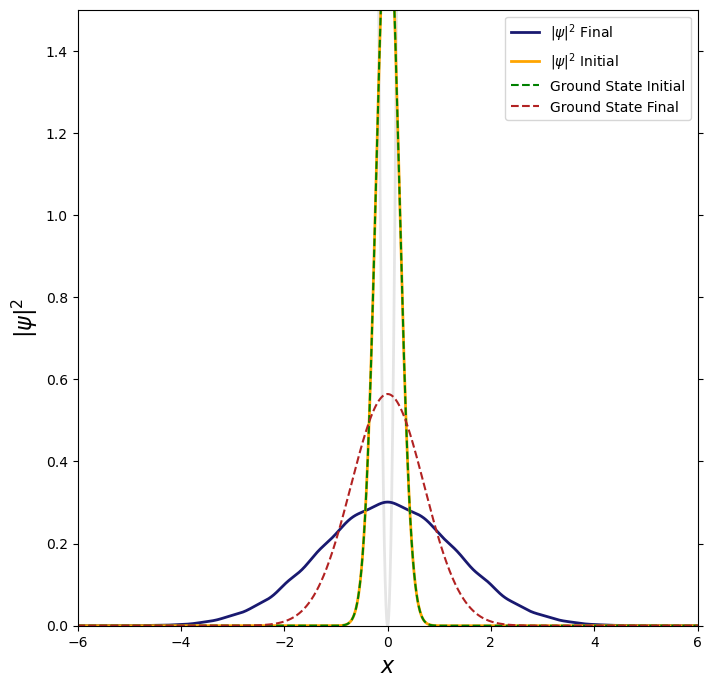

In [19]:
#Plot |psi|^2 #
fig=plt.figure(figsize=(8,8))
ax=fig.add_subplot(111)
ax.tick_params(right=True)

v=v_ho(grid.y,diag["tau"][0])

plt.plot(grid.y,v,linewidth=2.0,color='black',alpha=0.1)
plt.plot(grid.y,np.abs(psi_t[-1])**2,linewidth=2.0,color='midnightblue',label=r'$\vert \psi \vert^2$ Final')
plt.plot(grid.y,np.abs(psi_t[0])**2,linewidth=2.0,color='orange',label=r'$\vert \psi \vert^2$ Initial')

omegai = Omega_sched(diag["tau"][0])
psi_i_0 = psi.ho_eigenstate(grid.y,0,omegai)
plt.plot(grid.y,np.abs(psi_i_0)**2,linewidth=1.5,linestyle='dashed',color='green',label="Ground State Initial")

omegaf = Omega_sched(diag["tau"][-1])
psi_f_0 = psi.ho_eigenstate(grid.y,0,omegaf)

plt.plot(grid.y,np.abs(psi_f_0)**2,linewidth=1.5,linestyle='dashed',color='firebrick',label="Ground State Final")

plt.xlabel(r"$x$",fontsize=16)
plt.ylabel(r"$\vert \psi \vert^2$",fontsize=16)
#plt.figure(figsize=(20,20))
fig.set_facecolor("white")

plt.xlim(-6.0,6.0)
plt.ylim(0.0,1.5)

plt.legend()
plt.show()

In [23]:
import wavefunction_movies as movies

In [26]:
# Make a movie!

tau = diag["tau"]

# Precompute Omega(tau) and <N(tau)>
Omega_vals = np.array([float(Omega_sched(t)) for t in tau])
N_vals = psi.number_expectation(psi_t, grid.y, grid.k, grid.dy, tau, Omega_of_tau=Omega_sched)

outfile = movies.save_two_panel_movie(
    psi_t=psi_t,
    y=grid.y,
    tau=tau,
    Omega_vals=Omega_vals,
    N_vals=N_vals,
    potential_overlay=v_ho,
    outfile="ho_sudden_two_panel.mp4",
    what="abs2",
    stride=10,
    fps=20,
    title_left=r"$\vert \psi \vert^2$",
    title_right=r"$\omega(\tau) \;\; \mathrm{and}\;\; \langle \hat{N} \rangle(\tau)$",
    xlim_left=(-4, 4),
)

from IPython.display import Video
Video(outfile, embed=True)